In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
MODELS_INFO = {
    'gpt2-large': {
        'recurring': 'recurring__gsm8k__gpt2-large__output.json',
        'greedy': 'greedy__gsm8k__gpt2-large__output.json',
        'baseline': 'baseline__gsm8k__gpt2-large__output.json',
    },
    'gemma-2b': {
        'recurring': 'recurring__gsm8k__gemma-2b__output.json',
        'greedy': 'greedy__gsm8k__gemma-2b__output.json',
        'baseline': 'baseline__gsm8k__gemma-2b__output.json',
    },
    'gemma-7b': {
        'recurring':'recurring__gsm8k__gemma-7b__output.json',
        'greedy': 'greedy__gsm8k__gemma-7b__output.json',
        'baseline': 'baseline__gsm8k__gemma-7b__output.json',
    },
}

METHODS = ['recurring', 'greedy', 'baseline']

MAJORITY_THRESHOLD = 0.5

NUM_SAMPLES = [8, 16, 24]

RECURRING_TIMESTEPS = 3

In [3]:
def _answer_cleaning(sequence):
    answer = [s for s in re.findall(r'-?\d+\.?\d*', sequence.replace(",", ""))]
    if len(answer) == 0:
        return -np.inf
    return float(answer[-1][:-1] if answer[-1].endswith(".") else answer[-1])

def get_answer_distribution(sampled_sequences):
    answers = [_answer_cleaning(sequence) for sequence in sampled_sequences]
    if len(answers) == 0:
        return []
    answers, answer_counts = np.unique(answers, return_counts=True)
    distribution = list(zip([str(answer) for answer in answers], [answer_count/len(sampled_sequences) for answer_count in answer_counts]))
    return sorted(distribution, key=lambda x: x[1], reverse=True)

In [4]:
def conv_float(x):
    return float(x.replace(',', '')) if len(x) > 0 else float('-inf')

def correct_with_majority_threshold(instance, correct_answer, majority_threshold=0.5, timestep=RECURRING_TIMESTEPS):
    answer_distributions = instance['answer_distribution']
    
    termination_index = timestep-1
    for ts in range(termination_index):
        if answer_distributions[ts][0][1] >= majority_threshold:
            termination_index = ts
            break
    
    return conv_float(instance["majority_vote_answers"][termination_index]) == correct_answer

def get_accuracy(model_name, method, num_samples, majority_threshold=1, timestep=RECURRING_TIMESTEPS):
    if MODELS_INFO[model_name][method] is None:
        return 0
    file = os.path.join('../../results/', MODELS_INFO[model_name][method])
    output = json.load(open(file))
    
    if method == 'recurring':
        return sum(1 for inst in output if correct_with_majority_threshold(inst, conv_float(inst['ground_truth_answers']), majority_threshold, num_samples//8)) / len(output)
    elif method == 'baseline':
        return sum(1 for inst in output if conv_float(get_answer_distribution(inst['generated_sequences'][:num_samples])[0][0]) == conv_float(inst['ground_truth_answer'])) / len(output)
    elif method == 'greedy':
        return sum(1 for inst in output if conv_float(get_answer_distribution(inst['generated_sequences'])[0][0]) == conv_float(inst['ground_truth_answer'])) / len(output)
    raise ValueError('Invalid method')

In [5]:
plot_df = pd.DataFrame(columns=['Model', 'Method', 'Number of Samples', 'Accuracy'])

for model_name in MODELS_INFO:
    for method in METHODS:
        for num_samples in NUM_SAMPLES:
            if method == 'recurring':
                accuracy = get_accuracy(model_name, method, num_samples, MAJORITY_THRESHOLD)
                plot_df = pd.concat([plot_df, pd.DataFrame([{
                    'Model': model_name,
                    'Method': f"RCS (Our Approach)",
                    'Number of Samples': num_samples,
                    'Accuracy': accuracy
                }])], ignore_index=True)
            else:
                accuracy = get_accuracy(model_name, method, num_samples)
                plot_df = pd.concat([plot_df, pd.DataFrame([{
                    'Model': model_name,
                    'Method': "Self-Consistancy" if method == 'baseline' else 'Greedy',
                    'Number of Samples': num_samples,
                    'Accuracy': accuracy
                }])], ignore_index=True)

C:\Users\AADAM\AppData\Local\Temp\ipykernel_6588\2644986190.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame([{


In [6]:
plot_df.head(20)

,Model,Method,Number of Samples,Accuracy
0,gpt2-large,RCS (Our Approach),8,0.020701
1,gpt2-large,RCS (Our Approach),16,0.018881
2,gpt2-large,RCS (Our Approach),24,0.018995
3,gpt2-large,Greedy,8,0.013421
4,gpt2-large,Greedy,16,0.013421
5,gpt2-large,Greedy,24,0.013421
6,gpt2-large,Self-Consistancy,8,0.018995
7,gpt2-large,Self-Consistancy,16,0.020246
8,gpt2-large,Self-Consistancy,24,0.021724
9,gemma-2b,RCS (Our Approach),8,0.223612


[]

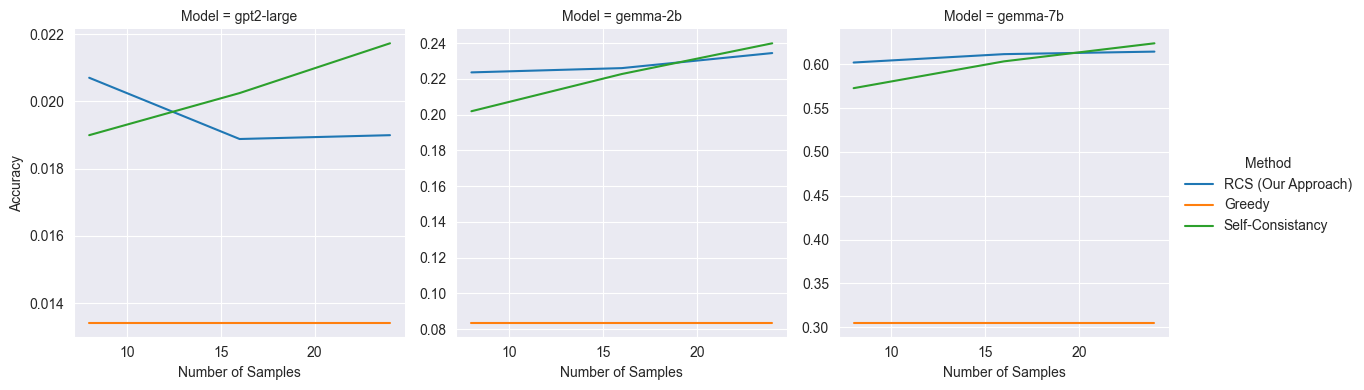

In [7]:
sns.set_style("darkgrid")
g = sns.FacetGrid(plot_df, col="Model", hue="Method", sharey=False, height=4)
g.map(sns.lineplot,'Number of Samples','Accuracy', markers=True)
g.add_legend()
plt.plot()